In [1]:
using Combinatorics
using BenchmarkTools
using Polynomials
using Plots
using Jacobi
using SparseArrays

In [2]:
##################
#sum_Tk 和 Prod_Tk是为了求laplace
#sum_Tk为(1)(2)
#Prod_Tk为(1)(2)中每一个乘积项
##################
function basis_function(N,d,x,k,range)
    Prod_Tk=zeros(N,N)
    Sum_Tk=zeros(1,N)
        for i=1:N
            for z=1:N
                Prod_temp=1
                for j=1:d
                    Prod_temp=Prod_temp*chebyshev(x[z,j],k[i,j])
                end
                Prod_Tk[i,z]=Prod_temp
            end
            Sum_Tk[i]=sum(Prod_Tk[i,:])
        end
    boundary_func=vcat(map(x->range^2-x^2, x))
    func_value=prod(Sum_Tk)*prod(boundary_func)
    #Sum_Tk=zeros(Float64,N)
    #Prod_Tk=zeros(Float64,N,N)
    #temp=[1.0*chebyshev(x[z,j],k[i,j]) for i=1:N for z=1:N for j=1:d]
    #temp=reshape(temp,d,N*N)
    #Prod_Tk=prod(temp,dims=1)
    #Prod_Tk=reshape(Prod_Tk,N,N)'
    #temp=prod(temp,dims=1)
    #temp=reshape(temp,N,N)
    #Sum_Tk=sum(temp,dims=1)'
    #temp=sum(temp,dims=1)
    #boundary_func=vcat(map(x->range^2-x^2, x))
    #func_value=prod(temp)*prod(boundary_func)
    return func_value,Sum_Tk,Prod_Tk,boundary_func
end

basis_function (generic function with 1 method)

In [3]:
##切比雪夫多项式二阶导
function d2chebyshev(x,k)
    chebyshev_Tk=Jacobi.chebyshev(x, k)
    chebyshev_Uk=Jacobi.chebyshev2(x, k)
    if x!=1&-1
        d2_Tk=k*((k+1)*chebyshev_Tk-chebyshev_Uk)/(x^2-1)
    end
    if x==1
        d2_Tk=(k^4-k^2)/3
    end
    if x==-1
        d2_Tk=(-1)^k*(k^4-k^2)/3
    end
    return d2_Tk
end

d2chebyshev (generic function with 1 method)

In [4]:
##基函数laplace
function laplace_psi(N,d,x,k,range)
    Sum_laplace=0
    Prod_laplace=0
    basisfunc=basis_function(N,d,x,k,range)[1]
    Sum_Tk=basis_function(N,d,x,k,range)[2]
    Prod_Tk=basis_function(N,d,x,k,range)[3]
        for dimension=1:d
            for N_x=1:N
                for i=1:N-1
                #################d2T####################
                d2T_k=d2chebyshev(x[N_x,dimension], k[i,dimension])
                T_k=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                Prod_laplace=basisfunc*d2T_k*Prod_Tk[i,N_x]/(Sum_Tk[i]*T_k)
                Sum_laplace+=Prod_laplace
                #################dTdT####################
                dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[i,dimension])
                T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                    for j=i+1:N
                    dT_kj=Jacobi.dchebyshev(x[N_x,dimension], k[j,dimension])
                    T_k_j=Jacobi.chebyshev(x[N_x,dimension], k[j,dimension])
                    Prod_laplace=basisfunc*dT_kj*dT_ki*Prod_Tk[i,N_x]*Prod_Tk[j,N_x]/(Sum_Tk[i]*Sum_Tk[j]*T_k_i*T_k_j)
                    Sum_laplace+=2*Prod_laplace
                    end
                #################dTdx####################
                Prod_laplace=-2*x[N_x,dimension]*basisfunc*dT_ki*Prod_Tk[i,N_x]/(Sum_Tk[i]*(range^2-x[N_x,dimension]^2)*T_k_i)
                Sum_laplace+=2*Prod_laplace
                end
            T_k=Jacobi.chebyshev(x[N_x,dimension], k[N,dimension])
            d2T_k=d2chebyshev(x[N_x,dimension], k[N,dimension])
            Prod_laplace=basisfunc*d2T_k*Prod_Tk[N,N_x]/(Sum_Tk[N]*T_k)
            Sum_laplace+=Prod_laplace
            T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[N,dimension])
            dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[N,dimension])
            Prod_laplace=-2*basisfunc*dT_ki*x[N_x,dimension]*Prod_Tk[N,N_x]/(Sum_Tk[N]*(range^2-x[N_x,dimension]^2)*T_k_i)
            Sum_laplace+=2*Prod_laplace
            #################d2x####################
            Sum_laplace+=-2*basisfunc/(range^2-x[N_x,dimension]^2)
            end
        end
    return Sum_laplace
end

laplace_psi (generic function with 1 method)

In [5]:
function V_psi(N,d,x,k,range)
    Sum_V=0
    Sum_r=sum(x.^2)
        Sum_V=basis_function(N,d,x,k,range)[1]*Sum_r
    return Sum_V
end

V_psi (generic function with 1 method)

In [6]:
function H_psi(N,d,x,k,range)
       Sum_H_psi=-1/2*laplace_psi(N,d,x,k,range)+1/2*V_psi(N,d,x,k,range)
    return Sum_H_psi
end

H_psi (generic function with 1 method)

In [7]:
#以M=3,N=2为例生成 
#3  0
#2  1
function nsumk(N,M)
    k=collect(partitions(M+N,N))
    k=vcat(map(e->collect(e)', k)...)
    k=k-ones(Int64,size(k))
    return k
end

nsumk (generic function with 1 method)

In [8]:
function find_k(d,N,M)
    k_all=zeros(Int64,1,N*d)
    for i=1:M
        dividers=nsumk(N*d,i)
        k_all=vcat(k_all, dividers)
    end
    k_all=sort!(k_all,dims =2)
    k_all=k_all'
    number_of_k=size(k_all)[2]
    i=0
    k=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
    k=vcat(map(e->collect(e)', k)...)
    for i=1:number_of_k-1
        k_temp=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
        k_temp=vcat(map(e->collect(e)', k_temp)...)
        k=vcat(k, k_temp)
        k=unique(k,dims=1)
    end
    k=k'
    number_of_k=size(k)[2]
    k=reshape(k,number_of_k*N*d)
    k=reshape(k,N,d,number_of_k)
    for i=1:number_of_k
        k[:,:,i]=sortslices(k[:,:,i],dims=1)
    end
    k=unique(k,dims=3)  
   return k
end

find_k (generic function with 1 method)

In [9]:
function random_choose(Number_of_x,d,N,k,range)
    Number_of_k=size(k)[3]
    random_choose_X=rand(N,d,Number_of_x).*rand([-range,range],N,d,Number_of_x)
    random_choose_psi_x=zeros(Number_of_k,Number_of_x)
    random_choose_Hpsi_x=zeros(Number_of_k,Number_of_x)
    for i=1:Number_of_k
        for j=1:Number_of_x
            random_choose_psi_x[i,j]=basis_function(N,d,random_choose_X[:,:,j],k[:,:,i],range)[1]
            random_choose_Hpsi_x[i,j]=H_psi(N,d,random_choose_X[:,:,j],k[:,:,i],range)
        end
    end
    return random_choose_psi_x,random_choose_Hpsi_x,random_choose_X
end

random_choose (generic function with 1 method)

In [10]:
function least_squares(least_squares_x,least_squares_y)
    least_squares_C_k=inv(least_squares_x'*least_squares_x)*least_squares_x'*least_squares_y
    return least_squares_C_k
end

least_squares (generic function with 1 method)

In [11]:
function Eigenvalue(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x = 10^(-20),eps_d=0.001,maxIterations = 100)
    record=spzeros(maxIterations)
    basisfunction=random_x[1]
    H_basisfunction=random_x[2]
    for t in 1:maxIterations
            #若更换选点，取消以下注释
            #step_interval=10
            #if mod(t,step_interval)==0
                #random_x=random_choose(Number_of_x,d,N,k,range)
                #basisfunction=random_x[1]
                #H_basisfunction=random_x[2]
            #end
            reilaygh_quotient=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[2]
            coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
            p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
            coef_H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[5]
            record[t]=reilaygh_quotient[1]
        if t>=3
            if abs(record[t]-record[t-1])+abs(record[t-1]-record[t-2])<=2*eps_d
                println("Convergence is reached after  ",t,"  iterations.")
                return coef,reilaygh_quotient,record
            end
        end
        alpha=steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,0,0.1,0.01,100)[1]
        println("============================步长为==========================",alpha)
        coef = coef-alpha*p
        println("At step ", t, " and reilaygh quotient = ", reilaygh_quotient)
    end
    println("Warning:",maxIterations,"  iterations have been exceeded")
    return coef,reilaygh_quotient,record
end

Eigenvalue (generic function with 1 method)

In [12]:
function reilaygh_quotient_alpha(coef_temp,basisfunction,H_basisfunction,N,d,range,Number_of_x)
        wave_temp=coef_temp*basisfunction
        sum_2_wave_temp=wave_temp*wave_temp'
        integal_wave_temp=(2*range)^(N*d)*sum_2_wave_temp/Number_of_x
        coef_temp=coef_temp/sqrt(integal_wave_temp[1])
        wave_temp=wave_temp/sqrt(integal_wave_temp[1])
        sum_2_wave_temp=sum_2_wave_temp/integal_wave_temp[1]
        H_wave_temp=coef_temp*H_basisfunction
        sum_wave_H_wave_temp=wave_temp*H_wave_temp'
        reilaygh_quotient_temp=sum_wave_H_wave_temp/sum_2_wave_temp
        coef_H_wave_temp=least_squares(basisfunction',H_wave_temp')
        coef_H_wave_temp=coef_H_wave_temp'
        p=coef_H_wave_temp-reilaygh_quotient_temp*coef_temp
    return reilaygh_quotient_temp,H_wave_temp,coef_temp,p,coef_H_wave_temp
end

reilaygh_quotient_alpha (generic function with 1 method)

In [13]:
function steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,a,b,eps_alpha,max)
        a_n=a
        b_n=b
        lambda=a+0.382*(b-a)
        mu=a+0.618*(b-a)
        phi_a=reilaygh_quotient_alpha(coef-a*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_b=reilaygh_quotient_alpha(coef-b*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
        phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
    for i=1:max
        if t<3
            if b_n-a_n<eps_alpha
                return lambda
            end
            b_n=mu
            mu=lambda
            phi_b=phi_mu
            phi_mu=phi_lambda
            lambda=a_n+0.382*(b_n-a_n)
            phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
            t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
            phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
        if t>=3
           if b_n-a_n<eps_alpha
                return mu
           end
                a_n=lambda
                lambda=mu
                phi_a=phi_lambda
                phi_lambda=phi_mu
                mu=a_n+0.618*(b_n-a_n)
                phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
                phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
                t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
                phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
    end
    println("Warning:",max,"  iterations have been exceeded")
    return lambda
end

steep (generic function with 1 method)

In [37]:
d=1
N=1
M=15
@time k=find_k(d,N,M)
Number_of_x=40000
range=5
@time random_x=random_choose(Number_of_x,d,N,k,range)
Number_k=size(k)[3]
coef=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
@time A=Eigenvalue(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)

  0.000298 seconds (1.01 k allocations: 84.969 KiB)
  1.062875 seconds (19.20 M allocations: 1.727 GiB, 18.83% gc time)
============================步长为==========================0.025737666753443203
At step 1 and reilaygh quotient = [16.474785979085617]
============================步长为==========================0.0437713936
At step 2 and reilaygh quotient = [14.216643891925894]
============================步长为==========================0.0236076
At step 3 and reilaygh quotient = [12.830841797492743]
============================步长为==========================0.056228606400000006
At step 4 and reilaygh quotient = [11.989075216322384]
============================步长为==========================0.0236076
At step 5 and reilaygh quotient = [11.268795568485508]
============================步长为==========================0.0493416787552
At step 6 and reilaygh quotient = [10.721905481997181]
============================步长为==========================0.0236076
At step 7 and reilaygh quotient = [10.260014890679

============================步长为==========================0.029181896800000003
At step 64 and reilaygh quotient = [1.5970237507850733]
============================步长为==========================0.0270525154224
At step 65 and reilaygh quotient = [1.5800488630329192]
============================步长为==========================0.029181896800000003
At step 66 and reilaygh quotient = [1.564314924078099]
============================步长为==========================0.0270525154224
At step 67 and reilaygh quotient = [1.5498385608624026]
============================步长为==========================0.029181896800000003
At step 68 and reilaygh quotient = [1.5363802577189971]
============================步长为==========================0.0270525154224
At step 69 and reilaygh quotient = [1.5238817220491534]
============================步长为==========================0.029181896800000003
At step 70 and reilaygh quotient = [1.5122120802112486]
============================步长为==========================0.029181896800000003


============================步长为==========================0.029181896800000003
At step 128 and reilaygh quotient = [0.8462837715203793]
============================步长为==========================0.0270525154224
At step 129 and reilaygh quotient = [0.8336824829651293]
============================步长为==========================0.029181896800000003
At step 130 and reilaygh quotient = [0.8211521155534969]
============================步长为==========================0.029181896800000003
At step 131 and reilaygh quotient = [0.8090192992600361]
============================步长为==========================0.0270525154224
At step 132 and reilaygh quotient = [0.7970011080206506]
============================步长为==========================0.029181896800000003
At step 133 and reilaygh quotient = [0.7854237973952757]
============================步长为==========================0.0270525154224
At step 134 and reilaygh quotient = [0.7739456572423745]
============================步长为==========================0.02918189680

============================步长为==========================0.0236076
At step 192 and reilaygh quotient = [0.5140512275820099]
============================步长为==========================0.0360674538294711
At step 193 and reilaygh quotient = [0.5133251059453526]
============================步长为==========================0.0236076
At step 194 and reilaygh quotient = [0.5125594973348312]
============================步长为==========================0.032623909022400005
At step 195 and reilaygh quotient = [0.5118922235469746]
============================步长为==========================0.0236076
At step 196 and reilaygh quotient = [0.5112270719897863]
============================步长为==========================0.0360674538294711
At step 197 and reilaygh quotient = [0.5106491596607822]
============================步长为==========================0.020165587777600004
At step 198 and reilaygh quotient = [0.510036871076842]
============================步长为==========================0.0583615757758432
At step 199 and r

============================步长为==========================0.0708181032
At step 256 and reilaygh quotient = [0.5001091131378599]
============================步长为==========================0.0236076
At step 257 and reilaygh quotient = [0.5001040630805889]
============================步长为==========================0.014592400000000002
At step 258 and reilaygh quotient = [0.5000954558465872]
============================步长为==========================0.09655508457760001
At step 259 and reilaygh quotient = [0.500093665958994]
============================步长为==========================0.09655508457760001
At step 260 and reilaygh quotient = [0.5000813222418726]
============================步长为==========================0.0270525154224
At step 261 and reilaygh quotient = [0.5000743630213178]
============================步长为==========================0.0124623332465568
At step 262 and reilaygh quotient = [0.5000686403587307]
============================步长为==========================0.09655508457760001
At step

([0.024297176803348742 5.626568182251725e-5 … -4.067861154522386e-14 3.960304198730313e-17], [0.5000231319039512],   [1     ]  =  16.4748
  [2     ]  =  14.2166
  [3     ]  =  12.8308
  [4     ]  =  11.9891
  [5     ]  =  11.2688
  [6     ]  =  10.7219
  [7     ]  =  10.26
  [8     ]  =  9.85098
  [9     ]  =  9.45811
  [10    ]  =  9.09642
            ⋮
  [278   ]  =  0.500031
  [279   ]  =  0.500031
  [280   ]  =  0.50003
  [281   ]  =  0.500028
  [282   ]  =  0.500027
  [283   ]  =  0.500027
  [284   ]  =  0.500026
  [285   ]  =  0.500024
  [286   ]  =  0.500023
  [287   ]  =  0.500023
  [288   ]  =  0.500023)

In [424]:
##########################
#求 d=1 N=3 M=2:20 reilaygh quotient变化
#运行时间较长
##########################
d=1
N=2
M=2
k=find_k(d,N,M)
range=5
Number_k=size(k)[3]
c_k=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
Number_of_x=40000
record_time=zeros(1,20)
println("=================================M=",M,"==============================================")
#println("========================选点并计算基函数值时间如下","==============================================")
#@time random_x=random_choose(Number_of_x,d,N,k,range)
time = @elapsed random_x=random_choose(Number_of_x,d,N,k,range)
record_time[1]=time
time = @elapsed df1=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]    
record_time[2]=time
#println("========================梯度下降时间如上","==============================================")
t=1
for M in 4:2:20
    println("=================================M=",M,"==============================================")
    k=find_k(d,N,M)
    Number_k=size(k)[3]
    c_k=ones(1,Number_k)
    #println("========================选点并计算基函数值时间如下","==============================================")
    time = @elapsed random_x=random_choose(Number_of_x,d,N,k,range)
    record_time[2*t+1]=time
    time = @elapsed df2=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]  
    record_time[2*t+2]=time
    #println("========================梯度下降时间如上","==============================================")
    record=hcat(df1, df2)
    df1=record
    t=t+1
end

=================================M=2==============================================
============================步长为==========================0.09655508457760001
At step 1 and reilaygh quotient = [8.062427636164442]
============================步长为==========================0.09655508457760001
At step 2 and reilaygh quotient = [6.804365415954524]
============================步长为==========================0.09655508457760001
At step 3 and reilaygh quotient = [4.770177898319571]
============================步长为==========================0.09655508457760001
At step 4 and reilaygh quotient = [2.9270640869951303]
============================步长为==========================0.09655508457760001
At step 5 and reilaygh quotient = [2.1945480956932895]
============================步长为==========================0.09655508457760001
At step 6 and reilaygh quotient = [2.0590206591336253]
============================步长为==========================0.09655508457760001
At step 7 and reilaygh quotient = [2.03934619132546

============================步长为==========================0.09655508457760001
At step 11 and reilaygh quotient = [3.361969926370608]
============================步长为==========================0.09655508457760001
At step 12 and reilaygh quotient = [2.7974774667081586]
============================步长为==========================0.09655508457760001
At step 13 and reilaygh quotient = [2.2469669598924904]
============================步长为==========================0.09655508457760001
At step 14 and reilaygh quotient = [1.804412587850854]
============================步长为==========================0.09655508457760001
At step 15 and reilaygh quotient = [1.5115554673801432]
============================步长为==========================0.09655508457760001
At step 16 and reilaygh quotient = [1.3455890331525286]
============================步长为==========================0.09655508457760001
At step 17 and reilaygh quotient = [1.2603320178476503]
============================步长为==========================0.096555084577

============================步长为==========================0.09655508457760001
At step 23 and reilaygh quotient = [1.1018496740734929]
============================步长为==========================0.09655508457760001
At step 24 and reilaygh quotient = [1.0864387716997637]
============================步长为==========================0.09655508457760001
At step 25 and reilaygh quotient = [1.0777477791683787]
============================步长为==========================0.09655508457760001
At step 26 and reilaygh quotient = [1.0728048922943931]
============================步长为==========================0.09655508457760001
At step 27 and reilaygh quotient = [1.0699524811985697]
============================步长为==========================0.09655508457760001
At step 28 and reilaygh quotient = [1.0682736965522668]
============================步长为==========================0.09655508457760001
At step 29 and reilaygh quotient = [1.0672616473508838]
============================步长为==========================0.0965550845

============================步长为==========================0.0708181032
At step 33 and reilaygh quotient = [1.0496420321284525]
============================步长为==========================0.0583615757758432
At step 34 and reilaygh quotient = [1.044433985664624]
============================步长为==========================0.07426233324655679
At step 35 and reilaygh quotient = [1.040839406896957]
============================步长为==========================0.056228606400000006
At step 36 and reilaygh quotient = [1.0379999588915478]
============================步长为==========================0.0798344122224
At step 37 and reilaygh quotient = [1.036075257681345]
============================步长为==========================0.050658321244800006
At step 38 and reilaygh quotient = [1.0345043183896399]
============================步长为==========================0.09655508457760001
At step 39 and reilaygh quotient = [1.0334511843745422]
============================步长为==========================0.047210503200000004
At s

============================步长为==========================0.056228606400000006
At step 23 and reilaygh quotient = [3.251999664236602]
============================步长为==========================0.047210503200000004
At step 24 and reilaygh quotient = [3.0475477245949665]
============================步长为==========================0.0527894968
At step 25 and reilaygh quotient = [2.856969501197127]
============================步长为==========================0.0493416787552
At step 26 and reilaygh quotient = [2.674702004146397]
============================步长为==========================0.0527894968
At step 27 and reilaygh quotient = [2.50423900465481]
============================步长为==========================0.047210503200000004
At step 28 and reilaygh quotient = [2.340011925462664]
============================步长为==========================0.0527894968
At step 29 and reilaygh quotient = [2.1860586367388013]
============================步长为==========================0.047210503200000004
At step 30 and reil

============================步长为==========================0.0347550845776
At step 86 and reilaygh quotient = [1.0061023730991012]
============================步长为==========================0.09655508457760001
At step 87 and reilaygh quotient = [1.0061016097284987]
============================步长为==========================0.0236076
At step 88 and reilaygh quotient = [1.0060993805834355]
============================步长为==========================0.09655508457760001
At step 89 and reilaygh quotient = [1.0060989153354014]
============================步长为==========================0.09655508457760001
At step 90 and reilaygh quotient = [1.0060979081331376]
============================步长为==========================0.0090181032
At step 91 and reilaygh quotient = [1.0060972326279332]
============================步长为==========================0.0090181032
At step 92 and reilaygh quotient = [1.0060972244692612]
Convergence is reached after  93  iterations.
=================================M=14==============

============================步长为==========================0.0360674538294711
At step 56 and reilaygh quotient = [1.1469495467315898]
============================步长为==========================0.029181896800000003
At step 57 and reilaygh quotient = [1.1293683900013376]
============================步长为==========================0.0360674538294711
At step 58 and reilaygh quotient = [1.113825170061317]
============================步长为==========================0.029181896800000003
At step 59 and reilaygh quotient = [1.1001655193036501]
============================步长为==========================0.0360674538294711
At step 60 and reilaygh quotient = [1.0881186045846796]
============================步长为==========================0.029181896800000003
At step 61 and reilaygh quotient = [1.0775669343819454]
============================步长为==========================0.0360674538294711
At step 62 and reilaygh quotient = [1.0682588324322189]
============================步长为==========================0.029181896800

============================步长为==========================0.09655508457760001
At step 119 and reilaygh quotient = [1.002371664034601]
============================步长为==========================0.0180344122224
At step 120 and reilaygh quotient = [1.0023598520104533]
============================步长为==========================0.09655508457760001
At step 121 and reilaygh quotient = [1.0023554355595754]
============================步长为==========================0.032623909022400005
At step 122 and reilaygh quotient = [1.0023441546930554]
============================步长为==========================0.047210503200000004
At step 123 and reilaygh quotient = [1.0023419099228539]
============================步长为==========================0.0180344122224
At step 124 and reilaygh quotient = [1.002337268524603]
============================步长为==========================0.09655508457760001
At step 125 and reilaygh quotient = [1.0023347758399273]
============================步长为==========================0.03606745382

============================步长为==========================0.0360674538294711
At step 14 and reilaygh quotient = [9.36796216905789]
============================步长为==========================0.020165587777600004
At step 15 and reilaygh quotient = [9.106666608162914]
============================步长为==========================0.032623909022400005
At step 16 and reilaygh quotient = [8.867490288955612]
============================步长为==========================0.020165587777600004
At step 17 and reilaygh quotient = [8.63508082143403]
============================步长为==========================0.0347550845776
At step 18 and reilaygh quotient = [8.415576903562487]
============================步长为==========================0.020165587777600004
At step 19 and reilaygh quotient = [8.190188628206457]
============================步长为==========================0.032623909022400005
At step 20 and reilaygh quotient = [7.973753940819361]
============================步长为==========================0.020165587777600004


============================步长为==========================0.025737666753443203
At step 78 and reilaygh quotient = [1.2808182183323893]
============================步长为==========================0.020165587777600004
At step 79 and reilaygh quotient = [1.257431662228342]
============================步长为==========================0.0270525154224
At step 80 and reilaygh quotient = [1.2359585513366222]
============================步长为==========================0.020165587777600004
At step 81 and reilaygh quotient = [1.215946426078029]
============================步长为==========================0.0236076
At step 82 and reilaygh quotient = [1.1973622578648755]
============================步长为==========================0.0236076
At step 83 and reilaygh quotient = [1.1807206173970461]
============================步长为==========================0.020165587777600004
At step 84 and reilaygh quotient = [1.1654890527378234]
============================步长为==========================0.0270525154224
At step 85 and rei

============================步长为==========================0.0180344122224
At step 141 and reilaygh quotient = [1.0011075553617834]
============================步长为==========================0.032623909022400005
At step 142 and reilaygh quotient = [1.0010413622795762]
============================步长为==========================0.0180344122224
At step 143 and reilaygh quotient = [1.000975168291272]
============================步长为==========================0.0270525154224
At step 144 and reilaygh quotient = [1.0009177890691132]
============================步长为==========================0.0180344122224
At step 145 and reilaygh quotient = [1.0008668065518027]
============================步长为==========================0.0347550845776
At step 146 and reilaygh quotient = [1.000824017513518]
============================步长为==========================0.014592400000000002
At step 147 and reilaygh quotient = [1.0007784510981157]
============================步长为==========================0.0673760909776
At step 1

============================步长为==========================0.0270525154224
At step 203 and reilaygh quotient = [1.0003551889646751]
============================步长为==========================0.011147484577600002
At step 204 and reilaygh quotient = [1.0003548694228774]
============================步长为==========================0.09655508457760001
At step 205 and reilaygh quotient = [1.0003547811091098]
============================步长为==========================0.0909818968
At step 206 and reilaygh quotient = [1.0003541642587102]
============================步长为==========================0.0090181032
At step 207 and reilaygh quotient = [1.0003537216210971]
============================步长为==========================0.020165587777600004
At step 208 and reilaygh quotient = [1.000353499225212]
============================步长为==========================0.0729474845776
At step 209 and reilaygh quotient = [1.0003534459850434]
============================步长为==========================0.0090181032
At step 210 a

============================步长为==========================0.038200000000000005
At step 51 and reilaygh quotient = [4.206757516148514]
============================步长为==========================0.011147484577600002
At step 52 and reilaygh quotient = [4.068613053715236]
============================步长为==========================0.0347550845776
At step 53 and reilaygh quotient = [3.936528146197871]
============================步长为==========================0.011147484577600002
At step 54 and reilaygh quotient = [3.816158264110361]
============================步长为==========================0.0347550845776
At step 55 and reilaygh quotient = [3.693324245050688]
============================步长为==========================0.011147484577600002
At step 56 and reilaygh quotient = [3.5753929290427435]
============================步长为==========================0.0347550845776
At step 57 and reilaygh quotient = [3.4598166204691085]
============================步长为==========================0.011147484577600002
At s

============================步长为==========================0.014592400000000002
At step 114 and reilaygh quotient = [1.0737763531114988]
============================步长为==========================0.0180344122224
At step 115 and reilaygh quotient = [1.0691034229056162]
============================步长为==========================0.014592400000000002
At step 116 and reilaygh quotient = [1.0648111109682972]
============================步长为==========================0.020165587777600004
At step 117 and reilaygh quotient = [1.0607552015487174]
============================步长为==========================0.0124623332465568
At step 118 and reilaygh quotient = [1.0569341056732324]
============================步长为==========================0.0270525154224
At step 119 and reilaygh quotient = [1.0532201003707404]
============================步长为==========================0.011147484577600002
At step 120 and reilaygh quotient = [1.0493411426658559]
============================步长为==========================0.03475508

============================步长为==========================0.014592400000000002
At step 176 and reilaygh quotient = [1.0008530082433098]
============================步长为==========================0.0180344122224
At step 177 and reilaygh quotient = [1.0008113910911645]
============================步长为==========================0.014592400000000002
At step 178 and reilaygh quotient = [1.0007744028543912]
============================步长为==========================0.0180344122224
At step 179 and reilaygh quotient = [1.0007380489250755]
============================步长为==========================0.014592400000000002
At step 180 and reilaygh quotient = [1.0007048948470443]
============================步长为==========================0.020165587777600004
At step 181 and reilaygh quotient = [1.0006730670019686]
============================步长为==========================0.014592400000000002
At step 182 and reilaygh quotient = [1.0006430373457915]
============================步长为==========================0.018034

============================步长为==========================0.0270525154224
At step 238 and reilaygh quotient = [1.0001392874518733]
============================步长为==========================0.011147484577600002
At step 239 and reilaygh quotient = [1.0001375078959334]
============================步长为==========================0.038200000000000005
At step 240 and reilaygh quotient = [1.0001359915088017]
============================步长为==========================0.0090181032
At step 241 and reilaygh quotient = [1.0001340264123788]
============================步长为==========================0.09655508457760001
At step 242 and reilaygh quotient = [1.0001322482717563]
============================步长为==========================0.0090181032
At step 243 and reilaygh quotient = [1.0001265782718955]
============================步长为==========================0.09655508457760001
At step 244 and reilaygh quotient = [1.0001251206977384]
============================步长为==========================0.0090181032
At step 

============================步长为==========================0.0124623332465568
At step 12 and reilaygh quotient = [13.297180761251662]
============================步长为==========================0.014592400000000002
At step 13 and reilaygh quotient = [13.02173770995693]
============================步长为==========================0.011147484577600002
At step 14 and reilaygh quotient = [12.750363626726214]
============================步长为==========================0.0124623332465568
At step 15 and reilaygh quotient = [12.50370110192134]
============================步长为==========================0.0124623332465568
At step 16 and reilaygh quotient = [12.267018919647807]
============================步长为==========================0.0124623332465568
At step 17 and reilaygh quotient = [12.057176092955974]
============================步长为==========================0.0124623332465568
At step 18 and reilaygh quotient = [11.845843289215194]
============================步长为==========================0.012462333246556

============================步长为==========================0.0124623332465568
At step 75 and reilaygh quotient = [5.134159196066917]
============================步长为==========================0.011147484577600002
At step 76 and reilaygh quotient = [5.049625824512768]
============================步长为==========================0.0124623332465568
At step 77 and reilaygh quotient = [4.968201852214264]
============================步长为==========================0.0124623332465568
At step 78 and reilaygh quotient = [4.884710331812292]
============================步长为==========================0.011147484577600002
At step 79 and reilaygh quotient = [4.805032704617369]
============================步长为==========================0.014592400000000002
At step 80 and reilaygh quotient = [4.723317343607948]
============================步长为==========================0.0090181032
At step 81 and reilaygh quotient = [4.644166597277972]
============================步长为==========================0.020165587777600004
At st

============================步长为==========================0.0124623332465568
At step 138 and reilaygh quotient = [1.5744232294144431]
============================步长为==========================0.011147484577600002
At step 139 and reilaygh quotient = [1.552065149320164]
============================步长为==========================0.0124623332465568
At step 140 and reilaygh quotient = [1.5297738086571075]
============================步长为==========================0.011147484577600002
At step 141 and reilaygh quotient = [1.5089812082660616]
============================步长为==========================0.0124623332465568
At step 142 and reilaygh quotient = [1.4881918835338657]
============================步长为==========================0.011147484577600002
At step 143 and reilaygh quotient = [1.4688912449657672]
============================步长为==========================0.0124623332465568
At step 144 and reilaygh quotient = [1.449525797360206]
============================步长为==========================0.011147

============================步长为==========================0.0090181032
At step 200 and reilaygh quotient = [1.0381933767508715]
============================步长为==========================0.0180344122224
At step 201 and reilaygh quotient = [1.0365120388352573]
============================步长为==========================0.0090181032
At step 202 and reilaygh quotient = [1.0346173937265128]
============================步长为==========================0.014592400000000002
At step 203 and reilaygh quotient = [1.032981376570717]
============================步长为==========================0.0090181032
At step 204 and reilaygh quotient = [1.0313776599873485]
============================步长为==========================0.020165587777600004
At step 205 and reilaygh quotient = [1.0300603085587163]
============================步长为==========================0.0090181032
At step 206 and reilaygh quotient = [1.0284102917463018]
============================步长为==========================0.014592400000000002
At step 207 and

============================步长为==========================0.0090181032
At step 263 and reilaygh quotient = [1.000637293536932]
============================步长为==========================0.0055742968000000006
At step 264 and reilaygh quotient = [1.000567980770359]
============================步长为==========================0.09655508457760001
At step 265 and reilaygh quotient = [1.0005566146660643]
============================步长为==========================0.0124623332465568
At step 266 and reilaygh quotient = [1.000416243194114]
============================步长为==========================0.0055742968000000006
At step 267 and reilaygh quotient = [1.0003862519894773]
============================步长为==========================0.09655508457760001
At step 268 and reilaygh quotient = [1.0003787440183185]
============================步长为==========================0.011147484577600002
At step 269 and reilaygh quotient = [1.0002896988932088]
============================步长为==========================0.005574296

============================步长为==========================0.0034449154224
At step 326 and reilaygh quotient = [1.000013415408875]
============================步长为==========================0.0034449154224
At step 327 and reilaygh quotient = [1.00001365938154]
============================步长为==========================0.09655508457760001
At step 328 and reilaygh quotient = [1.0000136936121966]
============================步长为==========================0.0180344122224
At step 329 and reilaygh quotient = [1.0000126403909344]
============================步长为==========================0.0034449154224
At step 330 and reilaygh quotient = [1.0000075141305265]
============================步长为==========================0.0034449154224
At step 331 and reilaygh quotient = [1.0000081086347208]
============================步长为==========================0.0034449154224
At step 332 and reilaygh quotient = [1.0000087218981906]
============================步长为==========================0.0034449154224
At step 333 and 

In [425]:
logocolors = Colors.JULIA_LOGO_COLORS
color_choose=(logocolors.blue, logocolors.red, logocolors.green, logocolors.purple)

(RGB{N0f8}(0.251,0.388,0.847), RGB{N0f8}(0.796,0.235,0.2), RGB{N0f8}(0.22,0.596,0.149), RGB{N0f8}(0.584,0.345,0.698))

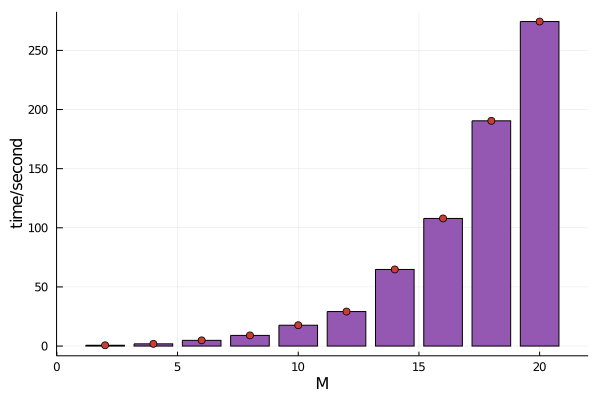

In [426]:
#画时间图
x=collect(2:2:20)
time=sum(reshape(record_time,2,:),dims=1)'
Plots.bar(x,time,linewidth=1,xlabel="M",ylabel="time/second",label="",color=color_choose[4],align="center")
scatter!(x,time,label="",color=color_choose[2])

In [427]:
Plots.savefig("t.svg")

In [430]:
true_value=N*d/2
record=df1
reilaygh_quotient_array=zeros(2000,1,10)
reilaygh_quotient_array_ln=zeros(2000,1,10)
for i=1:10
    reilaygh_quotient_array1=findall(!iszero, record[:,i])
    step=size(reilaygh_quotient_array1)
    temp=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
    for j=1:step[1]
        reilaygh_quotient_array[j,1,i]=temp[j]
    end
    reilaygh_quotient_array_ln[1:step[1],1,i]=map((x) -> log(abs(x)), reilaygh_quotient_array[1:step[1],1,i])
end

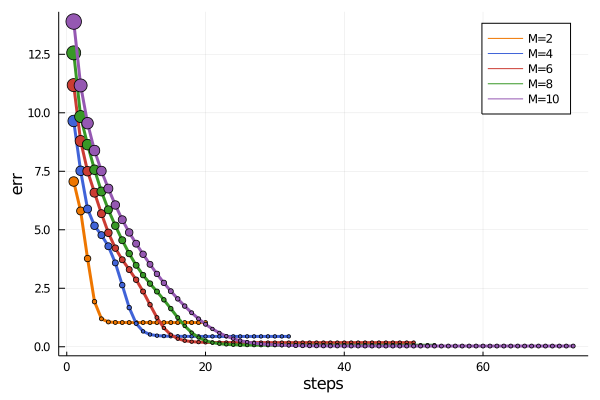

In [431]:
i=1
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=2:4
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-1])
    scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-1])
end
i=5
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-1])
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-1])

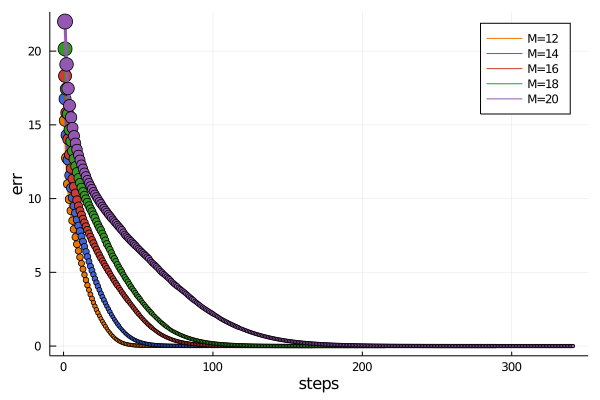

In [432]:
i=6
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=7:9
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-6])
    scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-6])
end
i=10
step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[i-6])
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 2, lab = "",color=color_choose[i-6])

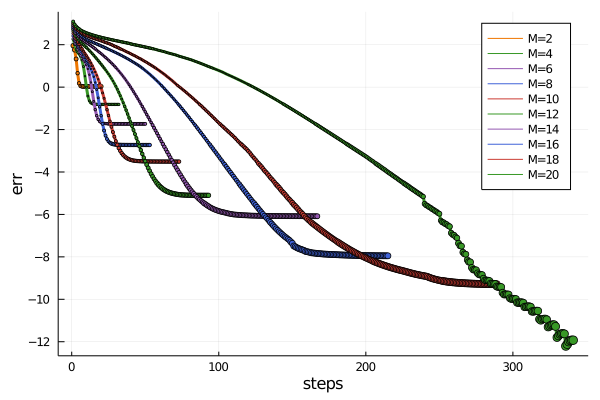

In [436]:
i=1
step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
plot(temp,w = 3,xlabel="steps",ylabel="ln_err",label=string("M=", 2*i),color="darkorange2")
scatter!(temp,ms = 0.5*abs.(temp .- 0.5) .+ 2, lab = "",color="darkorange2")
for i=2:9
    step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
    plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[mod(i,4)+1])
    scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 1, lab = "",color=color_choose[mod(i,4)+1])
end
i=10
step=size(findall(!iszero, reilaygh_quotient_array_ln[:,1,i]))[1]
temp=Array(reilaygh_quotient_array_ln[:,1,i][1:step[1]])
plot!(temp,w = 3,xlabel="steps",ylabel="err",label=string("M=", 2*i),color=color_choose[mod(i,4)+1])
scatter!(temp,ms = 0.3*abs.(temp .- 0.5) .+ 1, lab = "",color=color_choose[mod(i,4)+1])

In [437]:
err=zeros(1,10)
for i=1:10
    step=size(findall(!iszero, reilaygh_quotient_array[:,1,i]))[1]
    temp=Array(reilaygh_quotient_array[:,1,i][1:step[1]])
    err[i]=temp[step[1]][1]
end
err=err'
ln_err=map(x->log(abs(x)),err)

10×1 Array{Float64,2}:
   0.033996852547847525
  -0.8158161243105323
  -1.7300373629744625
  -2.727585872387118
  -3.50917138350454
  -5.099922360199835
  -6.086199235658271
  -7.950555241687053
  -9.289874448311679
 -11.926401298809893

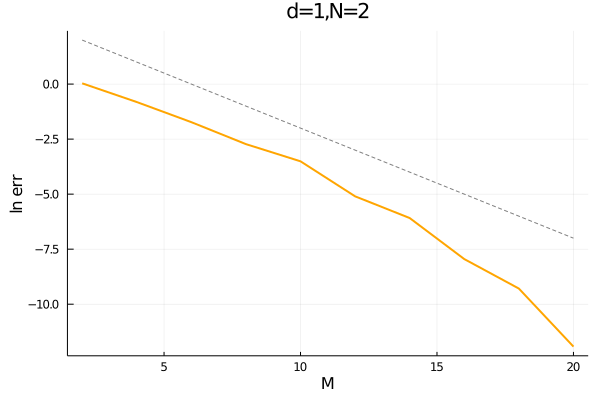

In [438]:
x=collect(2:2:20)
y=collect(2:-1:-7)
Plots.plot(x,ln_err,linewidth=2,label="",color="orange",xlabel="M",ylabel="ln err",title="d=1,N=2")
plot!(x,y,linewidth=1,ls=:dash,color="gray",label="")